In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('combined_processed.csv')

#useless once the new data is loaded
df = df.dropna()
df = df[df['player_one_colour'] != 'white']
df = df[df['player_two_colour'] != 'white'].reset_index(drop=True)
df['score_player_one'] = df['score_player_one'].apply(lambda x: int(x))
df['turns_played'] = df['turns_played'].apply(lambda x: int(x))

In [3]:
def get_df_for_pair(df_original: pd.DataFrame, town1: str, town2: str):
    '''plug in town2 as "all" to get statistics for town1 against all towns (except itself)'''
    
    df = df_original.copy()
    
    # Deals with town1
    town_on_left = df['player_one_town'] == town1
    town_on_right = df['player_two_town'] == town1
    mask = (town_on_left | town_on_right) & ~(town_on_left & town_on_right) #logical xor
    df = df[mask].reset_index(drop=True)
    
    # Inverts the statistics if needed. The town1 will always now be on the left (player 1)
    for i in range(df.shape[0]):
        row = df.loc[i]
        if row['player_two_town'] == town1:
            #town switching:
            row['player_one_town'], row['player_two_town'] = row['player_two_town'], row['player_one_town']
            #hero switching:
            row['player_one_town'], row['player_two_town'] = row['player_two_town'], row['player_one_town']
            #colour_switching:
            row['player_one_town'], row['player_two_town'] = row['player_two_town'], row['player_one_town']
            #bidding inversion:
            row['bidding_amount'] = -1*row['bidding_amount']
            df.loc[i] = row
    
    # Deals with town 2
    if town2 != 'all':
        df = df[df['player_two_town'] == town2]
        df = df.reset_index(drop=True)
        
    return df

In [4]:
df2 = get_df_for_pair(df, 'castle', 'all')

C:\Users\user\AppData\Local\Temp\ipykernel_10568\2512721945.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['player_one_town'], row['player_two_town'] = row['player_two_town'], row['player_one_town']
C:\Users\user\AppData\Local\Temp\ipykernel_10568\2512721945.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['player_one_town'], row['player_two_town'] = row['player_two_town'], row['player_one_town']
C:\Users\user\AppData\Local\Temp\ipykernel_10568\2512721945.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

In [5]:
def get_optimal_split(df):
    '''plug in a town vs. town dataframe'''
    
    df_won = df[df['score_player_one'] == 1.0]
    df_lost = df[df['score_player_one'] == 0.0]
    
    X_won = np.array(df_won['bidding_amount']).reshape(-1, 1)
    X_lost = np.array(df_lost['bidding_amount']).reshape(-1, 1)
    
    kmeans_won = KMeans(n_clusters=1, random_state=0, n_init=2).fit(X_won)
    kmeans_lost= KMeans(n_clusters=1, random_state=0, n_init=2).fit(X_lost)
    
    print(kmeans_won.cluster_centers_)
    print(kmeans_lost.cluster_centers_)
    
    optimal_value =  int((kmeans_won.cluster_centers_[0][0] + kmeans_lost.cluster_centers_[0][0])/2)
    
    return optimal_value

In [6]:
optimal_trade_value = get_optimal_split(df2)

C:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[466.25]]
[[-36.20689655]]


C:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [7]:
df['year-quarter'] = [0] * df.shape[0]
df['quarters_passed'] = [0] * df.shape[0]
for i in range(df.shape[0]):
    row = df.loc[i]
    date = datetime.strptime(row['created_at'], '%d/%m/%Y %H:%M')
    #The above converts the datetime into datetimes with year as year and quarter as month
    row['year-quarter'] = datetime(year = date.year, month = (date.month-1)//3 + 1, day=1)
    df.loc[i, 'year-quarter'] = row['year-quarter']
    df.loc[i, 'quarters_passed'] = row['year-quarter'].month + (row['year-quarter'].year-2021)*4

C:\Users\user\AppData\Local\Temp\ipykernel_10568\3731096463.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['year-quarter'] = datetime(year = date.year, month = (date.month-1)//3 + 1, day=1)


In [8]:
df

,player_one,score_player_one,player_two,score_player_two,winner,template,player_one_hero,player_two_hero,bidding_amount,ending_day,created_at,turns_played,player_one_town,player_one_colour,player_two_town,player_two_colour,template_type,year-quarter,quarters_passed
0,HawkWRz,0,Vertr0X,1.0,Vertr0X,h3dm1/3,gundula,crag hack,900,124,19/05/2021 08:21,11,stronghold,red,stronghold,blue,Mirror,2021-02-01 00:00:00,2
1,Bartt666,0,BOARtek,1.0,BOARtek,h3dm1/3,giselle,aeris,900,143,20/05/2021 14:49,24,rampart,red,rampart,blue,Mirror,2021-02-01 00:00:00,2
2,BOARtek,0,GALAXER00,1.0,GALAXER00,mt_Firewalk,octavia,xyron,-5500,136,21/05/2021 14:44,20,inferno,red,inferno,blue,Mirror,2021-02-01 00:00:00,2
3,Fafhrd,1,GALAXER00,0.0,Fafhrd,h3dm1/3,leena,jeremy,-900,122,21/05/2021 20:33,9,cove,red,cove,blue,Mirror,2021-02-01 00:00:00,2
4,Ardian,1,Deextereek,0.0,Ardian,h3dm1/3,eovacius,anabel,700,127,21/05/2021 20:38,14,cove,red,cove,blue,Mirror,2021-02-01 00:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,mirek_swirek,1,Shihtzu,0.0,mirek_swirek,6lm10a/tp,tyraxor,anabel,3600,123,26/02/2023 11:24,10,stronghold,red,cove,blue,XL+U,2023-01-01 00:00:00,9
3345,Sc@neR,0,Jabolpunk,1.0,Jabolpunk,6lm10a/tp,tyraxor,thant,3000,134,26/02/2023 19:52,18,stronghold,red,necropolis,blue,XL+U,2023-01-01 00:00:00,9
3346,Vens,1,GoldenCrow,0.0,Vens,6lm10a/tp,tyraxor,valeska,-5400,127,27/02/2023 19:34,14,stronghold,blue,castle,red,XL+U,2023-01-01 00:00:00,9
3347,rybson1,1,BOARtek,0.0,rybson1,mt_Andromeda,pasis,gelare,800,131,27/02/2023 21:22,15,conflux,blue,conflux,red,Mirror,2023-01-01 00:00:00,9


In [9]:
def get_regression_predictions(df, quarters=5) -> tuple:
    '''"quarters" determines how many quarters into the future we would like to see'''
    
    #Get the independent values (X), so just the quarters passed
    X_medians = df['quarters_passed'].unique().reshape(-1, 1)
    X_bottom_quantiles = df['quarters_passed'].unique().reshape(-1, 1)
    X_top_quantiles = df['quarters_passed'].unique().reshape(-1, 1)
    
    #Get the outcomes (bid median and quantiles):
    y_medians = np.array(df.groupby(['year-quarter'])['bidding_amount'].median())
    y_bottom_quantiles = np.array(df.groupby(['year-quarter'])['bidding_amount'].quantile(0.2))
    y_top_quantiles = np.array(df.groupby(['year-quarter'])['bidding_amount'].quantile(0.8))
    
    #Generate the models (median and quantiles models):
    lm_medians = LinearRegression().fit(X = X_medians, y = y_medians)
    lm_bottom_quantiles = LinearRegression().fit(X = X_bottom_quantiles, y = y_bottom_quantiles)
    lm_top_quantiles = LinearRegression().fit(X = X_top_quantiles, y = y_top_quantiles)
    
    # Create the next quarters to predict upon:
    X_pred = [[df['quarters_passed'].max()+i+1] for i in range(quarters)]
    
    # Create the predictions:
    y_pred_medians = lm_medians.predict(X_pred)
    y_pred_bottom_quantiles = lm_bottom_quantiles.predict(X_pred)
    y_pred_top_quantiles = lm_top_quantiles.predict(X_pred)
    
    # Extract the inner lists from X_pred:
    X_pred = [element[0] for element in X_pred]
    
    # Round the predictions:
    y_pred_medians = [int(element) for element in y_pred_medians]
    y_pred_bottom_quantiles = [int(element) for element in y_pred_bottom_quantiles]
    y_pred_top_quantiles = [int(element) for element in y_pred_top_quantiles]
    
    # Append the quarters and predictions into the ground values:
    y_medians = list(y_medians) + y_pred_medians
    y_bottom_quantiles = list(y_bottom_quantiles) + y_pred_bottom_quantiles
    y_top_quantiles = list(y_top_quantiles) + y_pred_top_quantiles
    
    # Returning as a dataframe:
    df_predictions = pd.DataFrame({'quarters_passed': list(df['quarters_passed'].unique())+X_pred, 'median': y_medians,
                                   'bottom_quantile': y_bottom_quantiles, 'top_quantile': y_top_quantiles})
    return df_predictions

In [10]:
df_predictions = get_regression_predictions(df, 5)

In [11]:
df_predictions

,quarters_passed,median,bottom_quantile,top_quantile
0,2,-500.0,-2680.0,2500.0
1,3,-100.0,-2300.0,2040.0
2,4,0.0,-2020.0,2000.0
3,5,-500.0,-2680.0,2100.0
4,6,-500.0,-2500.0,2340.0
5,7,100.0,-900.0,1700.0
6,8,0.0,-2400.0,2600.0
7,9,0.5,-2500.0,2700.0
8,10,43.0,-2017.0,2437.0
9,11,94.0,-1965.0,2479.0


### Prepare the dataframe purely for the tree classifier:

In [12]:
df_tree = df[['score_player_one', 'player_one_town', 'player_one_hero', 'player_one_colour', 'player_two_town',
             'player_two_hero', 'bidding_amount', 'turns_played', 'template_type']]

df_tree_no_heroes = df[['score_player_one', 'player_one_town', 'player_one_colour', 
                        'player_two_town', 'bidding_amount', 'turns_played', 'template_type']]

In [13]:
#other classifier for mirrors and for non-mirrors will be needed
df_tree = df_tree[df_tree['template_type'] == 'XL+U'] 
df_tree_no_heroes = df_tree_no_heroes[df_tree_no_heroes['template_type'] == 'XL+U']

In [14]:
df_tree_one_hot = pd.get_dummies(df_tree, drop_first=True).dropna().reset_index(drop=True)
df_tree_no_heroes_one_hot = pd.get_dummies(df_tree_no_heroes, drop_first=True).dropna().reset_index(drop=True)

In [29]:
df_tree_no_heroes_one_hot

,score_player_one,bidding_amount,turns_played,player_one_town_conflux,player_one_town_cove,player_one_town_dungeon,player_one_town_fortress,player_one_town_inferno,player_one_town_necropolis,player_one_town_rampart,...,player_one_colour_red,player_two_town_conflux,player_two_town_cove,player_two_town_dungeon,player_two_town_fortress,player_two_town_inferno,player_two_town_necropolis,player_two_town_rampart,player_two_town_stronghold,player_two_town_tower
0,1,-700,18,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,0,-2900,14,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,1300,21,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,2800,2,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,-1800,22,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,0,0,32,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1785,0,-1900,12,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1786,1,3600,10,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1787,0,3000,18,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [33]:
X = df_tree_one_hot.drop('score_player_one', axis=1)
X_no_heroes = df_tree_no_heroes_one_hot.drop('score_player_one', axis=1)

y = df_tree_one_hot['score_player_one']

In [26]:
clf = DecisionTreeClassifier(random_state=0, splitter='best', max_depth = 5, min_samples_split = 5, max_features = 1)

In [27]:
clf.fit(X_no_heroes, y)

DecisionTreeClassifier(max_depth=5, max_features=1, min_samples_split=5,
                       random_state=0)

IndexError: list index out of range

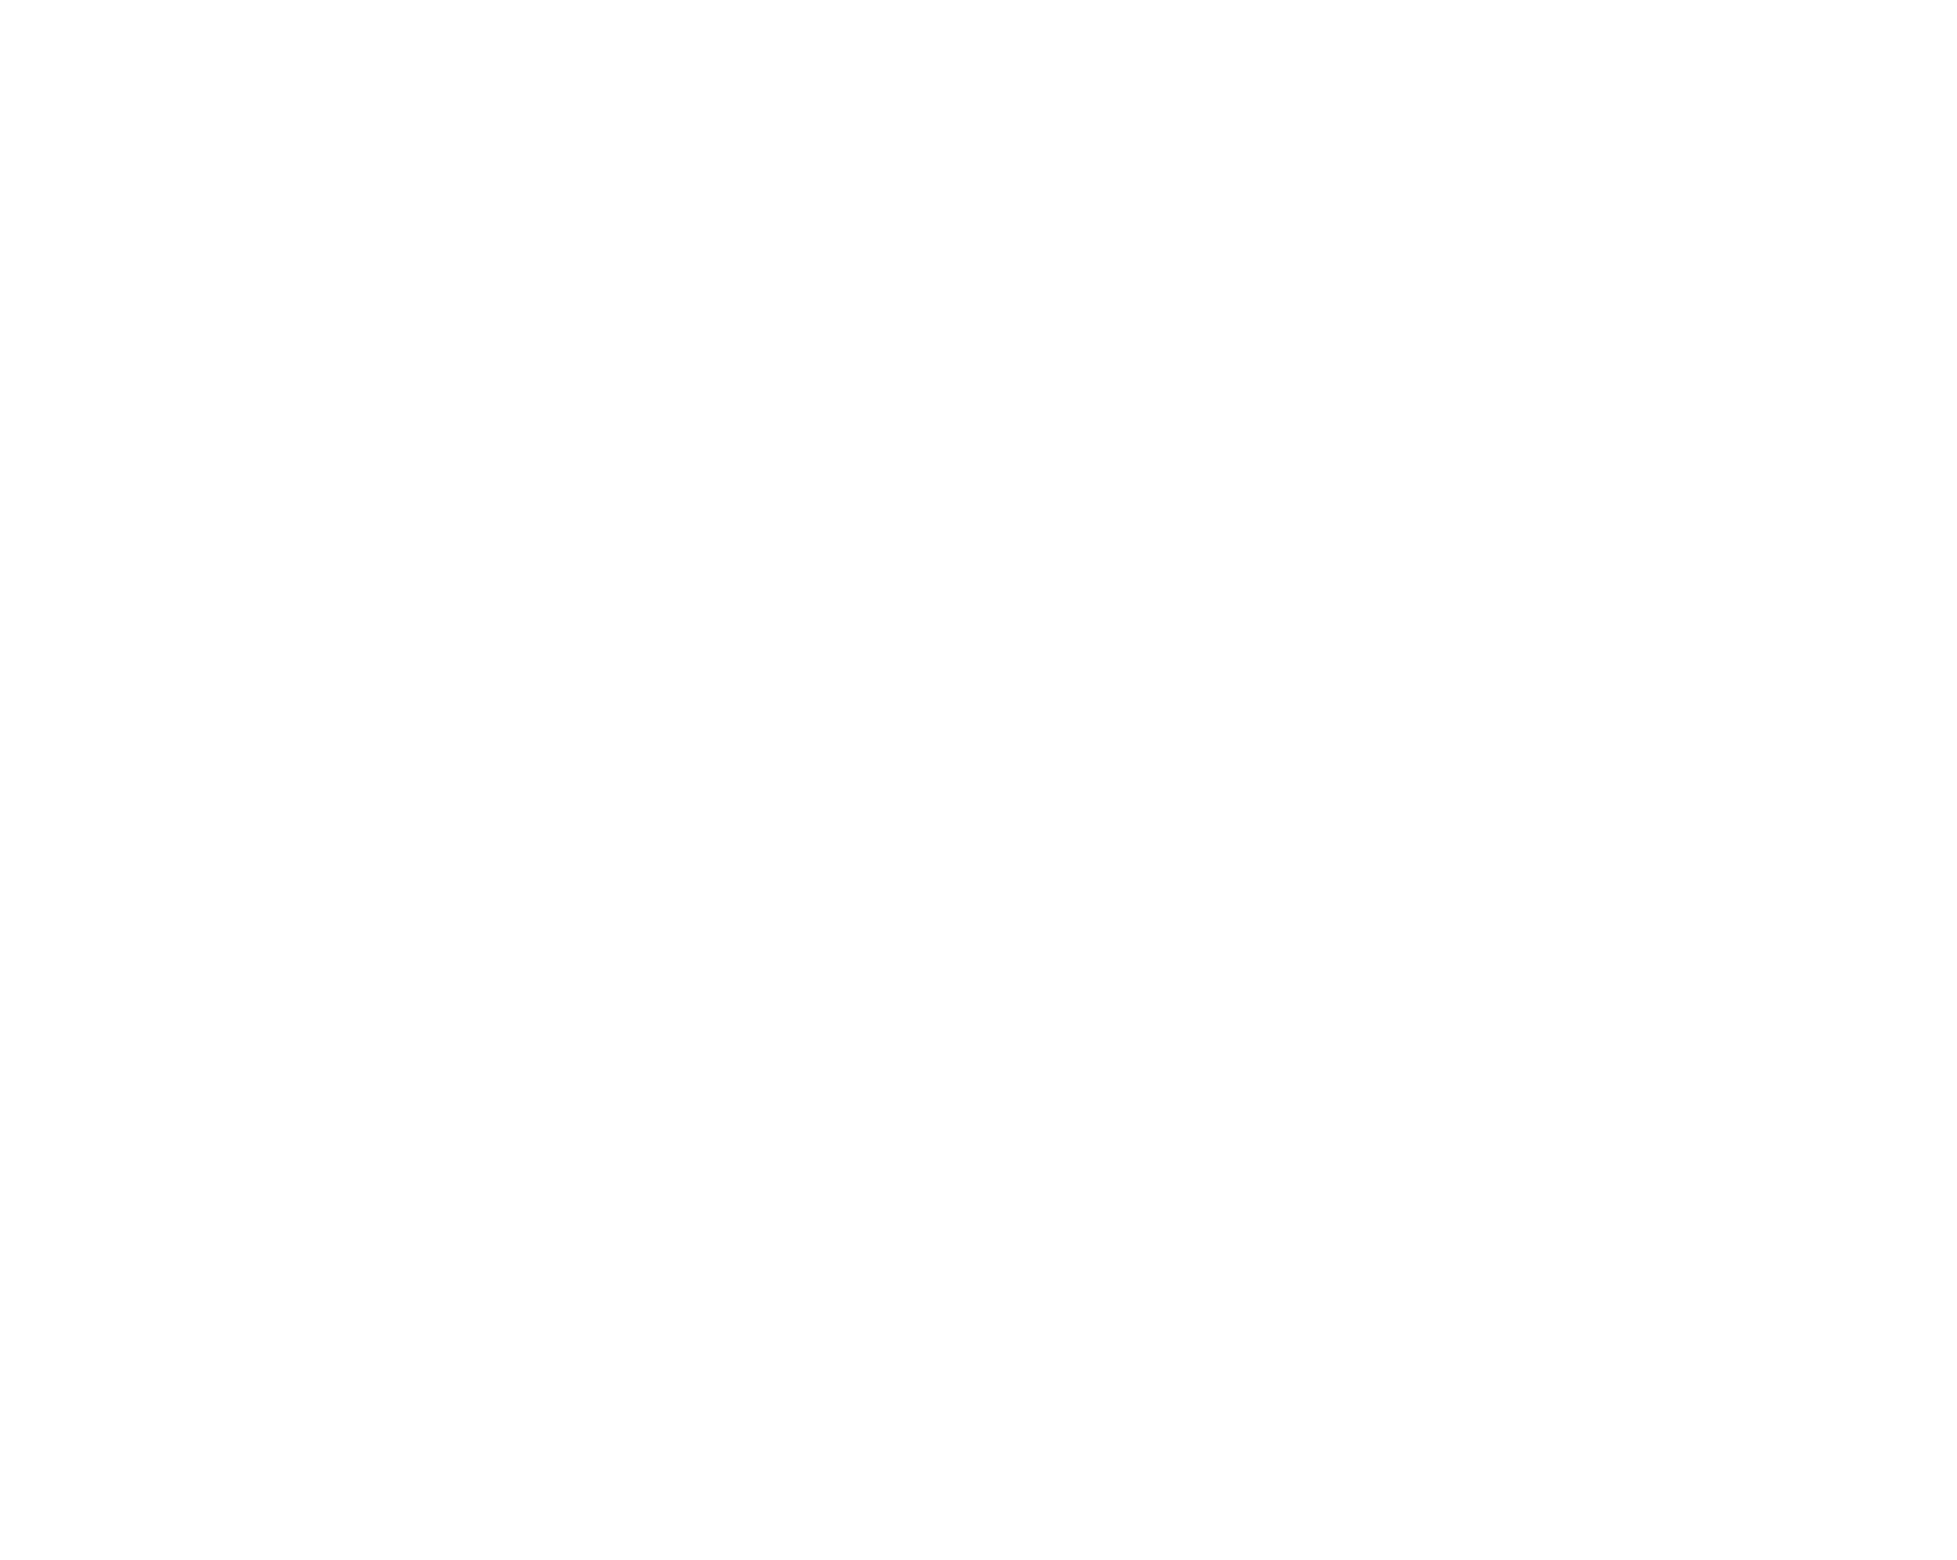

In [28]:
fig = plt.figure(figsize=((25,20)))
plot_tree(clf,
            feature_names = X_no_heroes.columns,
            class_names=['loss', 'win'], 
            impurity=False,
            proportion=True,
            filled=True)
#fig.savefig('test.png')